<a href="https://colab.research.google.com/github/aniketgupta1997/Devanagari/blob/master/Devanagari_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
num_classes = 18
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract('Train.tar')
test_folders = maybe_extract('Test.tar')

Extracting data for Train. This may take a while. Please wait.
['Train/character_11_taamatar', 'Train/character_13_daa', 'Train/character_16_tabala', 'Train/character_18_da', 'Train/character_1_ka', 'Train/character_21_pa', 'Train/character_25_ma', 'Train/character_26_yaw', 'Train/character_27_ra', 'Train/character_28_la', 'Train/character_29_waw', 'Train/character_30_motosaw', 'Train/character_32_patalosaw', 'Train/character_33_ha', 'Train/character_3_ga', 'Train/character_4_gha', 'Train/character_6_cha', 'Train/character_8_ja']
Extracting data for Test. This may take a while. Please wait.
['Test/character_11_taamatar', 'Test/character_13_daa', 'Test/character_16_tabala', 'Test/character_18_da', 'Test/character_1_ka', 'Test/character_21_pa', 'Test/character_25_ma', 'Test/character_26_yaw', 'Test/character_27_ra', 'Test/character_28_la', 'Test/character_29_waw', 'Test/character_30_motosaw', 'Test/character_32_patalosaw', 'Test/character_33_ha', 'Test/character_3_ga', 'Test/character_4_

In [21]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (plt.imread(image_file,0).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 1700)
test_datasets = maybe_pickle(test_folders, 300)

Train/character_11_taamatar.pickle already present - Skipping pickling.
Train/character_13_daa.pickle already present - Skipping pickling.
Train/character_16_tabala.pickle already present - Skipping pickling.
Train/character_18_da.pickle already present - Skipping pickling.
Train/character_1_ka.pickle already present - Skipping pickling.
Train/character_21_pa.pickle already present - Skipping pickling.
Train/character_25_ma.pickle already present - Skipping pickling.
Train/character_26_yaw.pickle already present - Skipping pickling.
Train/character_27_ra.pickle already present - Skipping pickling.
Train/character_28_la.pickle already present - Skipping pickling.
Train/character_29_waw.pickle already present - Skipping pickling.
Train/character_30_motosaw.pickle already present - Skipping pickling.
Train/character_32_patalosaw.pickle already present - Skipping pickling.
Train/character_33_ha.pickle already present - Skipping pickling.
Train/character_3_ga.pickle already present - Skippi

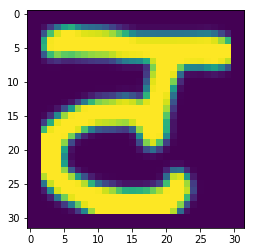

In [22]:
pickle_file = train_datasets[0]  

# With would automatically close the file after the nested block of code
with open(pickle_file, 'rb') as f:
    
    # unpickle
    letter_set = pickle.load(f)  
    
    # pick a random image index
    sample_idx = np.random.randint(len(letter_set))
    
    # extract a 2D slice
    sample_image = letter_set[sample_idx, :, :]  
    plt.figure()
    
    # display it
    plt.imshow(sample_image) 

In [23]:
import torch
from torch.utils.data import Dataset,DataLoader
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 30600
valid_size = 0
test_size = 5400

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)
trainloader=torch.utils.data.DataLoader(train_dataset,batch_size=18,shuffle=True)
print('Training:', train_dataset.shape, train_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (30600, 32, 32) (30600,)
Testing: (5400, 32, 32) (5400,)


In [0]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)


In [25]:
print(train_dataset.shape)
print(train_labels.shape)

(30600, 32, 32)
(30600,)


In [9]:
from keras.utils import np_utils
train_labels= np_utils.to_categorical(train_labels,18)
test_labels = np_utils.to_categorical(test_labels, 18)

Using TensorFlow backend.


In [26]:
train_dataset = train_dataset.reshape(train_dataset.shape[0], 1,32, 32)
test_dataset = test_dataset.reshape(test_dataset.shape[0], 1, 32, 32)
print(train_dataset.shape)
print(train_labels.shape)


(30600, 1, 32, 32)
(30600,)


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 18)
        self.fc4=nn.LogSoftmax()
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x=self.fc4(x)
       
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
      

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [29]:
import torch
t_l = torch.FloatTensor(train_labels)
t_d = torch.FloatTensor(train_dataset)
print (train_dataset.shape)
from torch.utils.data import TensorDataset
train_ds = TensorDataset(t_d,t_l)


(30600, 1, 32, 32)


In [14]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_ds,0):
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = data
        inputs=inputs.unsqueeze(0)
        #inputs=inputs.reshape(1,1,32,32)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

 
        for k in range(18):
          if (labels[k]==1):
        #    print (k)
            t=torch.tensor([k])

        t=t.type(torch.LongTensor)
        

        loss = criterion(outputs, t)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 2.891
[1,  4000] loss: 2.490
[1,  6000] loss: 1.391
[1,  8000] loss: 0.920
[1, 10000] loss: 0.642
[1, 12000] loss: 0.507
[1, 14000] loss: 0.448
[1, 16000] loss: 0.382
[1, 18000] loss: 0.342
[1, 20000] loss: 0.337
[1, 22000] loss: 0.294
[1, 24000] loss: 0.282
[1, 26000] loss: 0.277
[1, 28000] loss: 0.276
[1, 30000] loss: 0.250
[2,  2000] loss: 0.197
[2,  4000] loss: 0.214
[2,  6000] loss: 0.172
[2,  8000] loss: 0.185
[2, 10000] loss: 0.161
[2, 12000] loss: 0.176
[2, 14000] loss: 0.182
[2, 16000] loss: 0.135
[2, 18000] loss: 0.123
[2, 20000] loss: 0.143
[2, 22000] loss: 0.119
[2, 24000] loss: 0.144
[2, 26000] loss: 0.131
[2, 28000] loss: 0.146
[2, 30000] loss: 0.097
[3,  2000] loss: 0.100
[3,  4000] loss: 0.106
[3,  6000] loss: 0.082
[3,  8000] loss: 0.108
[3, 10000] loss: 0.083
[3, 12000] loss: 0.117
[3, 14000] loss: 0.100
[3, 16000] loss: 0.098
[3, 18000] loss: 0.073
[3, 20000] loss: 0.099
[3, 22000] loss: 0.071
[3, 24000] loss: 0.084
[3, 26000] loss: 0.101
[3, 28000] 

In [15]:
test_l = torch.FloatTensor(test_labels)
test_d = torch.FloatTensor(test_dataset)
print (test_dataset.shape)

test_ds = TensorDataset(test_d,test_l)
correct = 0

for i, data in enumerate(test_ds, 0):
  test_x, test_y = data
  test_x=test_x.unsqueeze(0)
  pred = net.forward(test_x)
  for k in range(18):
    if(test_y[k]==1):
      t=torch.tensor([k])
  t=t.type(torch.LongTensor)
  y_hat = np.argmax(pred.data)
 # print (y_hat)
#  print(t)
  if y_hat == t:
    correct += 1

print("Accuracy={}".format(correct / len(test_dataset)))

(5400, 1, 32, 32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy=0.9690740740740741


In [30]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True)
print (train_labels)
for index, (train_indices, test_indices) in enumerate(skf.split(train_dataset, train_labels)):
  
  print("Training on fold " + str(index+1) + "/10...")
  
  xtrain, xtest = train_dataset[train_indices], train_dataset[test_indices]
  ytrain, ytest = train_labels[train_indices], train_labels[test_indices]
  
  ytrain = np_utils.to_categorical(ytrain, 18)
  ytest = np_utils.to_categorical(ytest, 18)
  
  net1=Net()
  criterion1 = nn.CrossEntropyLoss()
  optimizer1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

  t_l = torch.FloatTensor(ytrain)
  t_d = torch.FloatTensor(xtrain)
  train_ds = TensorDataset(t_d,t_l)
  for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_ds,0):
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = data
        inputs=inputs.unsqueeze(0)
        #inputs=inputs.reshape(1,1,32,32)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

 
        for k in range(18):
          if (labels[k]==1):
        #    print (k)
            t=torch.tensor([k])

        t=t.type(torch.LongTensor)
        

        loss = criterion(outputs, t)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

  print('Finished Training')
  
  print("Training new iteration on " + str(xtrain.shape[0]) + " training samples, " + str(xtest.shape[0]) + " validation samples")
  test_l = torch.FloatTensor(ytest)
  test_d = torch.FloatTensor(xtest)
  print (test_dataset.shape)

  test_ds = TensorDataset(test_d,test_l)
  correct = 0

  for i, data in enumerate(test_ds, 0):
    test_x, test_y = data
    test_x=test_x.unsqueeze(0)
    pred = net.forward(test_x)
    for k in range(18):
      if(test_y[k]==1):
        t=torch.tensor([k])
    t=t.type(torch.LongTensor)
    y_hat = np.argmax(pred.data)
    if y_hat == t:
      correct += 1

  print("Accuracy={}".format(correct / len(test_dataset)))
  

[ 6 13 12 ...  7  9  8]
Training on fold 1/10...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 2.884
[1,  4000] loss: 2.227
[1,  6000] loss: 1.232
[1,  8000] loss: 0.796
[1, 10000] loss: 0.637
[1, 12000] loss: 0.511
[1, 14000] loss: 0.428
[1, 16000] loss: 0.410
[1, 18000] loss: 0.366
[1, 20000] loss: 0.309
[1, 22000] loss: 0.293
[1, 24000] loss: 0.267
[1, 26000] loss: 0.276
[2,  2000] loss: 0.273
[2,  4000] loss: 0.221
[2,  6000] loss: 0.242
[2,  8000] loss: 0.179
[2, 10000] loss: 0.185
[2, 12000] loss: 0.181
[2, 14000] loss: 0.143
[2, 16000] loss: 0.141
[2, 18000] loss: 0.139
[2, 20000] loss: 0.107
[2, 22000] loss: 0.134
[2, 24000] loss: 0.133
[2, 26000] loss: 0.125
[3,  2000] loss: 0.149
[3,  4000] loss: 0.126
[3,  6000] loss: 0.124
[3,  8000] loss: 0.109
[3, 10000] loss: 0.110
[3, 12000] loss: 0.115
[3, 14000] loss: 0.101
[3, 16000] loss: 0.106
[3, 18000] loss: 0.068
[3, 20000] loss: 0.065
[3, 22000] loss: 0.085
[3, 24000] loss: 0.103
[3, 26000] loss: 0.079
[4,  2000] loss: 0.072
[4,  4000] loss: 0.078
[4,  6000] loss: 0.106
[4,  8000] loss: 0.079
[4, 10000] 